<a href="https://colab.research.google.com/github/nilmeier/DSatEnterpriseScale/blob/master/Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Monte Carlo Approach

# Exam 2

In [ ]:
# Importing libraries
import pandas as pd
#from numpy import *
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Plot settings
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['lines.linewidth'] = 2.0

# Set max row to 300
pd.set_option('display.max_rows', 300)

#make figures printer friendly
%matplotlib inline


In [ ]:
from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!ls /content/gdrive/MyDrive/Colab\ Notebooks/*py

import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')
import helper_functions
import bse_functions

import importlib
importlib.reload(helper_functions)
importlib.reload(bse_functions)
helper_functions.say_hello()



'/content/gdrive/MyDrive/Colab Notebooks/bse_functions.py'
'/content/gdrive/MyDrive/Colab Notebooks/helper_functions.py'
hello


Monte Carlo methods are any process that consumes random numbers. These are part of computational algorithms which are based on random sampling to obtain numerical results. Monte Carlo methods are proved to be a very valuable and flexible computational tool in finance and is one of the most widely used methods for optimization and numerical integration problems.

These methods are widely used in high dimensional problems; pricing exotics and complex derivatives where closed form solutions are not directly available. Monte Carlo methods are not just adapted in pricing complex derivatives, It is also extensively used in estimating the portfolio risk such as Value-at-Risk and Expected Shortfall and used in the calculation of worst-case scenarios in stress testing. The downside to that is, it is very computational intensive and demanding.

## Monte Carlo Simulation

A method of estimating the value of an unknown quantity using the principles of inferential statistics.

We take the **population** and then we **sample** it by drawing a proper subset. And then we make an inference about the population based upon some set of statistics we do on the sample.

And, the key fact that makes them work, that if we choose the sample at random, the sample will tend to exhibit the same properties as the population from which it is drawn.

## Option Pricing (maybe don't keep this section?)

As with other option pricing techniques Monte Carlo methods are used to price options using what is essentially a three step process.

Step 1: 

1.   Simulate potential price paths of the underlying asset.
2.   Calculate the option payoff for each of these price paths.
3.   Average the payoff and discount back to today to determine the option price. 

##Simulating Asset Prices

Next, we will simulate the asset price at maturity $S_T$. Following Black-Scholes-Merton where the underlying follows under risk neutrality, a geometric Brownian motion with a stochastic differential equation (SDE) is given as

$$dS_t = r S_t dt + \sigma S_t d W_t \tag{A},$$

where $S_t$ is the price of the underlying at time $t$, $σ$ is constant volatility, $r$ is the constant risk-free interest rate and $W$ is the Brownian motion.

Applying the Euler-Maruyama discretization gives

$$S_{t+\delta t}=S_t⋅(1+r \delta t + \sigma \sqrt{\delta t} w_t) \tag{B}.$$

The Milstein discretization is (see below for derivation)

$$S_{t+\delta t} = S_t\cdot[1+r \delta t + \sigma \sqrt{\delta t} w_t+\frac{\sigma^2}{2}\delta t\cdot(w_t^2 -1)]\tag{C}$$


The variable $w_t$ is a standard normally distributed random variable, or Wiener variate, for the time interval $0 < 
\delta t < T$. It also holds $0 < t ≤ T$ with T the final time horizon.

These two simulation protocols are implemented in the module `helper_functions.py`. The function to be called is `simulate_path`.  This function will generate a trajectory where, at each step of a number of `timesteps`, normal variates are generated.  Depending on which protocol is specified, equation (C) or (D) will be applied at each time step.  The resulting trajectories (for all time) and histograms (at $T$ only), along with the bins used for histogramming, are returned.

In [ ]:
importlib.reload(helper_functions)
# Assign simulated price path to dataframe for analysis and plotting

params = {}
params['s0']=100
params['mu']=0.05
params['sigma']=0.2
params['horizon']=1
params['timesteps']=252
params['num_bins']=1000
params['num_sims']=500000
params['sim_types']= ['Euler-Maruyama', 'Milstein']
params['strike'] = 100
params['dividend']=0

#running full trajectory simulations here
import time
%time
s_plt, spath, h_s = helper_functions\
      .generate_simulation_and_histograms(params)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
generating simulation for Euler-Maruyama
using Euler-Maruyama
generating simulation for Milstein
using Milstein
done with simulations!


In [ ]:


%time s_plt, spath, h_s = helper_functions\
      .generate_simulation_and_histograms(params)


generating simulation for Euler-Maruyama
using Euler-Maruyama
generating simulation for Milstein
using Milstein
done with simulations!
CPU times: user 14.2 s, sys: 882 ms, total: 15 s
Wall time: 14.9 s


## Simulating at Expiry Only

The solution to our SDE (Equation A), following the usual application of Itô's Lemma, (JNDB: refer to endnotes?) gives: 

$$S_{t+\delta t}=S_t\cdot \exp\left[ \left(  r-\frac{\sigma^2}{2} \right)\delta t + \sigma \sqrt{\delta t}w_t \right ]\tag{D}.$$

This expression holds for an arbitrarily long time step $\delta t$.  It still contains the Wiener normal variate as part of the solution, which means we still need to generate many samples and collect statistics in order to obtain a distribution.  
It has the sometimes advantageous property of generating a distribution only at a given time, which is much faster than generating a full time series.  It is not useful, however, when computing path dependent options numerically.  

The function `ST_large_step` in the module `helper_functions` is used to generate a number of normal variates and apply equation (D) to generate a distribution of of asset prices at an arbitrary time $T$.  The resulting histogram of asset prices is returned.

In [ ]:
S_T = helper_functions.ST_large_step(params)
                  #sim_type=sim_type)

# computing histogram explicitly here
h_s['Time Stepping'],binEdges = np.histogram(S_T,\
                 range=(s_plt[0], s_plt[-1]),\
                 bins=params['num_bins'])

## Closed Form Distribution of Asset Price Under Geometric Brownian Motion

Rearranging the Time Stepping equation, or equation (D), gives:
$$\ln\left(\frac{S_{t+δt}}{S_t}\right)= \left(r-\frac{\sigma^2}{2} \right)\delta t+ \sigma \sqrt{\delta t}w_t \tag{E}$$  

For asset prices under geometric Brownian motion, the logarithm of the asset price is a normal distribution.  To see this, let's rewrite equation (E) as:

$$\ln(\hat S) = \hat \mu \cdot \delta t + \hat \sigma \cdot w_t \tag{E}$$



\begin{align}
\hat S&=\frac{\hat S_{t+δt}}{S_t}\\
\hat\mu&=r-\frac{\sigma^2}{2}\\
\hat \sigma &= \sigma \sqrt{\delta t}
\end{align}

When written this way, we can more easily see that this Brownian motion results in the logarithm of asset prices being normally distributed $ln(\hat S)\sim (\hat \mu, \hat \sigma)$, or

$$p\left(\ln(\hat S)\right) = \frac{1}{\hat\sigma\sqrt{2\pi}}\exp\left(\frac{-\left(\ln(\hat S)-\hat \mu\right)^2}{2\hat\sigma^2} \right)\tag{F}$$

Equation (F) describes the well known **lognormal distribution**.  The probability distribution under change of variables $p(ln(\ln(\hat S))\rightarrow p_{\hat S}(\hat S)$ is a well known result (and nontrivial to derive), and is given as:


$$p_{\hat S}(\hat S) = \frac{1}{\hat S\hat\sigma\sqrt{2\pi}}\exp\left(\frac{-\left(\ln(\hat S)-\hat \mu\right)^2}{2\hat\sigma^2} \right) \tag{G}$$


In [ ]:
h_s['Lognormal Distribution'] = helper_functions.S_closed_form(s_plt, params)

## Comparing Histograms
We can now compare the histograms $h_S(S_T)$ from each procedure and see that they are converging to the same result.  The closed form distribution is the only one that does not rely on multiple simulations, and as such, we will compare our simulated results to that distribution.  First, we must normalize the histograms.  The unnormalized histogram, $H_S(S_T)$, is the total number counts times $S_T$ occurs within each bin, and 
$$h_S(S_T)=\frac{H_S(S_T)}{\sum_i{H_S(S_{T,i}})}$$

In [ ]:
#normalizing all histograms
for sim in h_s.keys():
  h_s[sim] = h_s[sim]/np.sum(h_s[sim])

plotting Euler-Maruyama
plotting Milstein
plotting Time Stepping


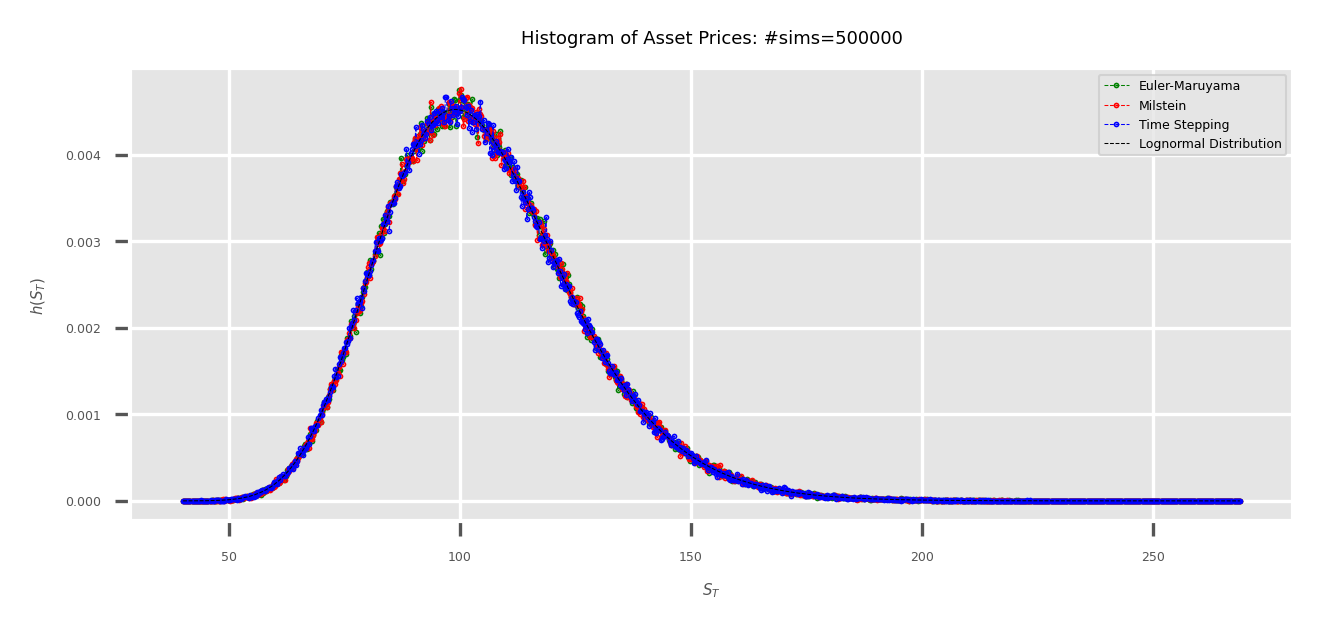

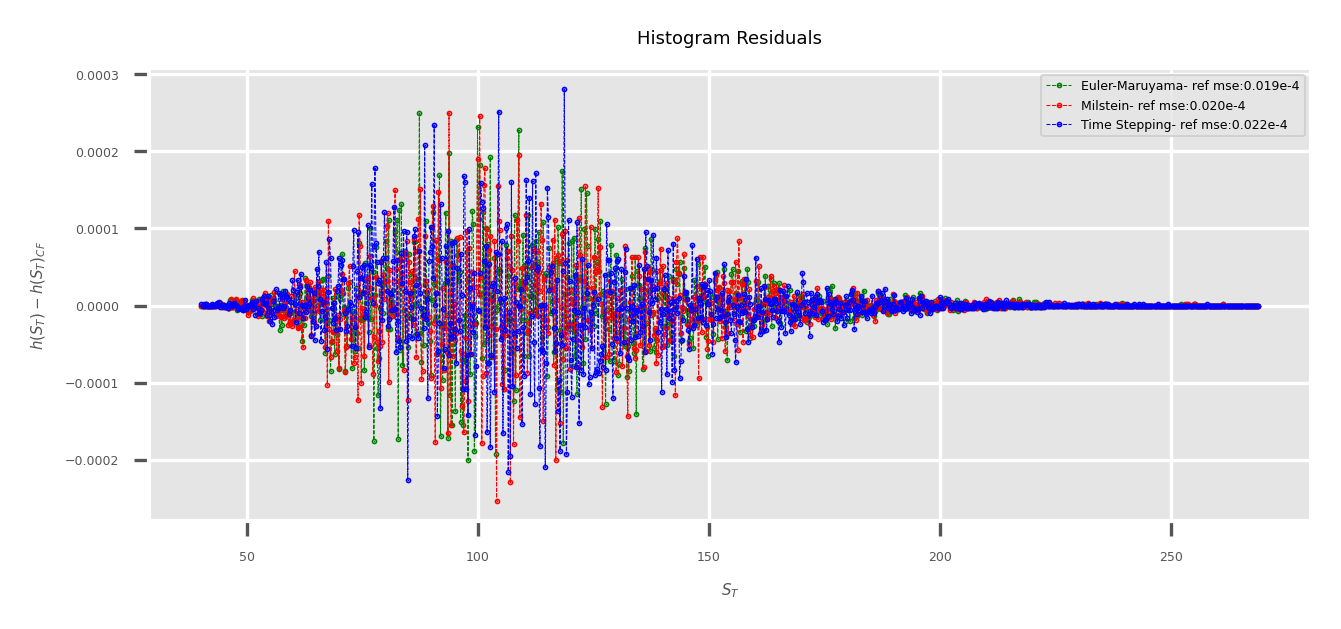

{'Euler-Maruyama': 1.8639171133503004e-06,
 'Milstein': 1.9767009595504387e-06,
 'Time Stepping': 2.1878846993331553e-06}

105.12704368318705

In [ ]:
mse = helper_functions.plot_histogram_comparison(s_plt, h_s, params)
display(mse)
np.sum(h_s['Lognormal Distribution']*s_plt)

## Using Time Stepping and Closed Form Distributions to Compute Options Prices

Need to clarify what is going on here

In [ ]:
#computing all (full trajectory) simulation based option prices
options = helper_functions.\
        fundamental_asset_price_formula(spath, params)

# computing path independent options with distributions of S_T
options = helper_functions.\
          price_from_distributions(options,s_plt,h_s,params)
display(options)

working on Euler-Maruyama
working on Milstein
working on Time Stepping
104.99466777100663
104.99466777100663
working on Lognormal Distribution
105.12704368318705
105.12704368318705


,Option Style,Option Type,Value,Solver
0,vanilla,call,10.434952,Euler-Maruyama
1,vanilla,put,5.559755,Euler-Maruyama
2,Asian,call,5.751414,Euler-Maruyama
3,Asian,put,3.339940,Euler-Maruyama
4,binary,call,0.532808,Euler-Maruyama
5,binary,put,0.418421,Euler-Maruyama
6,lookback,call,16.602196,Euler-Maruyama
7,lookback,put,13.431047,Euler-Maruyama
8,vanilla,call,10.434046,Milstein
9,vanilla,put,5.558452,Milstein


## Comparison to Bloomberg Terminal Calculations

JNDB:  Say something here...they are attached at the end of the notes

In [ ]:
options = helper_functions.update_with_Bloomberg_calcs(options)

display(options[options.Solver=='Bloomberg'])

,Option Style,Option Type,Value,Solver
20,vanilla,call,10.40,Bloomberg
21,vanilla,put,5.62,Bloomberg
22,Asian,call,3.38,Bloomberg
23,Asian,put,5.78,Bloomberg
24,binary,call,0.53,Bloomberg
25,binary,put,0.42,Bloomberg
26,lookback,call,16.51,Bloomberg
27,lookback,put,13.41,Bloomberg


## Using Black-Scholes and Related Closed Form Solutions
- add all equation descriptions here

In [ ]:
#%%time

from math import * # this is required for some of the maths functions

def CDF(X):
    (a1,a2,a3,a4,a5) = (0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    x=np.abs(X)
    k=1/(1+0.2316419*x)
    n=(1/np.sqrt(2*pi))*np.exp(-0.5*x**2)
    N=1.0-n*(a1*k+a2*k**2+a3*k**3+a4*k**4+a5*k**5)
    if X<0:
        N=1.0-N
    return N
#_______________________________________________________________________________________

def d1(stock,strike,r,sigma,tau):
    Moneyness=np.log(stock/strike)
    shift=r+0.5*sigma**2
    d1=(Moneyness+shift*tau)/(sigma*sqrt(tau))
    #print(d1)
    return d1
#_______________________________________________________________________________________

def d2(d1,sigma,tau):
    d2=d1-sigma*sqrt(tau)
    return d2
#_______________________________________________________________________________________

def call_option(d1,d2,stock,strike,r,tau):
    call=stock*CDF(d1)-exp(-r*tau)*strike*CDF(d2)
    return call

#_______________________________________________________________________________________

def put_option(d1,d2,stock,strike,r,tau):
    put=-stock*CDF(-d1)+exp(-r*(tau))*strike*CDF(-d2)
    return put
#_______________________________________________________________________________________

#_______________________________________________________________________________________

def binary_call_option(d1,d2,stock,strike,r,tau):
    b_call=exp(-r*(tau))*CDF(d2)
    return b_call
#_______________________________________________________________________________________


#_______________________________________________________________________________________

def binary_put_option(d1,d2,stock,strike,r,tau):
    b_put=exp(-r*(tau))*(1-CDF(d2))
    return b_put
#_______________________________________________________________________________________


# Asian Options Formula
def m1(stock,r,tau):
  return (np.exp(r*tau)-1)/(r*tau)*stock

def m2(stock, r, sigma, tau):
  t1 = 2*np.exp((2*r+sigma**2)*tau)*stock**2
  t1 = t1/((r+sigma**2)*(2*r+sigma**2)*tau**2)

  t2 = 2*stock**2/(r*tau**2)
  t2 = t2*(1/(2*r+sigma**2) - np.exp(r*tau)/(r+sigma**2))
  return (t1 + t2)




def asian_option(stock,strike, r, sigma, tau, type):
  
  m1_ = m1(stock,r,tau)
  m2_ = m2(stock,r, sigma,tau)
  stock_ = m1_
  sigma_ = np.sqrt(1/tau*np.log(m2_/m1_**2))
  d1_ = d1(stock_,strike,r,sigma_,tau)
  d2_ = d2(d1_,sigma_,tau)

  if type=='call':
    return np.exp(-r*tau)*(stock_*CDF(d1_)-strike*CDF(d2_))
  if type=='put':
    return np.exp(-r*tau)*(strike*CDF(-d2_)-stock_*CDF(-d1_))


stock=params['s0']
strike=params['strike']
r = params['mu']
sigma = params['sigma']
tau = params['horizon']
#div = params['dividend']
print('pre-stock, strike,r, sigma, tau', stock,strike,r,sigma,tau)
d1_ = d1(stock,strike,r,sigma,tau)
d2_ = d2(d1_,sigma,tau)
print(f'pre-d1, d2 {d1_, d2_}')


print("The asian call has price, ", asian_option(stock,strike,r,sigma,tau,type='call'))
print('\n\n')
print("The asian put has price, ", asian_option(stock,strike,r,sigma,tau,type='put'))
print('\n\n')


#print("The asian call has price, ", asian_option(stock=50,strike=50,r=0.1,\
#                                                 sigma=0.4,tau=1,type='call'))

pre-stock, strike,r, sigma, tau 100 100 0.05 0.2 1
pre-d1, d2 (0.35000000000000003, 0.15000000000000002)
The asian call has price,  5.42103020742908



The asian put has price,  3.0028216589283394





In [ ]:
import bse_functions
importlib.reload(bse_functions)
'''
def update_with_closed_form_calculations(options, params):
  stock=params['s0']
  strike=params['strike']
  r = params['mu']
  sigma = params['sigma']
  tau = params['horizon']
  
  d1_ = d1(stock,strike,r,sigma,tau)
  d2_ = d2(d1_,sigma,tau)  
  
  V = call_option(d1_,d2_,stock,strike,r,tau)
  options.loc[len(options.index)]=['vanilla','call',V,'BSE']
  V = put_option(d1_,d2_,stock,strike,r,tau)
  options.loc[len(options.index)]=['vanilla','put',V,'BSE']
  
  V = asian_option(stock,strike,r,sigma,tau,type='call')
  options.loc[len(options.index)]=['Asian','call',V,'BSE']
  
  V = asian_option(stock,strike,r,sigma,tau,type='put')
  options.loc[len(options.index)]=['Asian','put',V,'BSE (Approximate)']
  
  V = binary_call_option(d1_,d2_,stock,strike,r,tau)
  options.loc[len(options.index)]=['binary','call',V,'BSE']
  V = binary_put_option(d1_,d2_,stock,strike,r,tau)
  options.loc[len(options.index)]=['Asian','put',V,'BSE']

  return options'''
   

# options_new = update_with_closed_form_calculations(options, params)
options_new = bse_functions.update_with_closed_form_calculations(options, params)

# display(options[ options.Solver=="BSE"])
# display(options[ options.Solver=="BSE"])

In [ ]:
'''
stock=params['s0']
strike=params['strike']
r = params['mu']
sigma = params['sigma']
tau = params['horizon']
#div = params['dividend']
print('stock, strike,r, sigma, tau', stock,strike,r,sigma,tau)
d1_ = d1(stock,strike,r,sigma,tau)
d2_ = d2(d1_,sigma,tau)
print(f'd1, d2 {d1_, d2_}')
print(stock,r,tau)
#m1 = m1(stock,r,tau)
#m2 = m2(stock,r, tau, sigma)

print("The call has price, ", call_option(d1_,d2_,stock,strike,r,tau))
print("The put is valued at, ", put_option(d1_,d2_,stock,strike,r,tau))
print("The binary call has price, ", binary_call_option(d1_,d2_,stock,strike,r,tau))
print("The binary put has price, ", binary_put_option(d1_,d2_,stock,strike,r,tau))

print("The asian call has price, ", asian_option(stock,strike,r,sigma,tau,type='call'))
#print('\n\n')
print("The asian put has price, ", asian_option(stock,strike,r,sigma,tau,type='put'))
#print('\n\n')
'''

'\nstock=params[\'s0\']\nstrike=params[\'strike\']\nr = params[\'mu\']\nsigma = params[\'sigma\']\ntau = params[\'horizon\']\n#div = params[\'dividend\']\nprint(\'stock, strike,r, sigma, tau\', stock,strike,r,sigma,tau)\nd1_ = d1(stock,strike,r,sigma,tau)\nd2_ = d2(d1_,sigma,tau)\nprint(f\'d1, d2 {d1_, d2_}\')\nprint(stock,r,tau)\n#m1 = m1(stock,r,tau)\n#m2 = m2(stock,r, tau, sigma)\n\nprint("The call has price, ", call_option(d1_,d2_,stock,strike,r,tau))\nprint("The put is valued at, ", put_option(d1_,d2_,stock,strike,r,tau))\nprint("The binary call has price, ", binary_call_option(d1_,d2_,stock,strike,r,tau))\nprint("The binary put has price, ", binary_put_option(d1_,d2_,stock,strike,r,tau))\n\nprint("The asian call has price, ", asian_option(stock,strike,r,sigma,tau,type=\'call\'))\n#print(\'\n\n\')\nprint("The asian put has price, ", asian_option(stock,strike,r,sigma,tau,type=\'put\'))\n#print(\'\n\n\')\n'

In [ ]:
'''options[(options['Option Style']=='vanilla') & \
        (options['Option Type'] =='call')].append(\
options[(options['Option Style']=='vanilla') & \
        (options['Option Type'] =='put')]                                                  )
'''

#display(options)
options_summary = options[options['Option Type']=='call']\
                .rename(columns={"Value":"Call Value"})
options_put = options[options['Option Type']=='put'][['Value']]
#display(options_put)
options_summary['Put Value'] = options_put.iloc[:,0].values
#removing put values from table now that they are in the summary as a column
options_summary = options_summary[options['Option Type']=='call']



#display(options_summary)
options_summary[options_summary['Option Style']=='vanilla']
#display(options_summary)

#condition
vanilla_opts=options_summary['Option Style']=='vanilla'
options_summary.loc[vanilla_opts, 'Source of Truth']='BSE'
asian_opts=options_summary['Option Style']=='Asian'
options_summary.loc[asian_opts, 'Source of Truth']='Bloomberg'
binary_opts=options_summary['Option Style']=='binary'
options_summary.loc[binary_opts, 'Source of Truth']='Bloomberg'
lookback_opts=options_summary['Option Style']=='lookback'
options_summary.loc[lookback_opts, 'Source of Truth']='Bloomberg'

#display(options_summary.head(5))

for ind in options_summary.index:
  
  print(ind, options_summary.loc[ind,'Source of Truth'])
  #print('row of interest')
  #display(ind, options_summary[options_summary.index==ind])
  #V_ind = options_summary.loc[ind,'Call Value']
 
  o_style = options_summary.loc[ind,'Option Style']
  #o_type = options_summary.loc[ind,'Option Type']
  SoT_solver = options_summary.loc[ind,'Source of Truth']
  
  V_SoT_row = options_summary[(options_summary['Option Style']==o_style) &\
                         (options_summary['Solver']==SoT_solver) ]
  
  V_ind = options_summary.loc[ind,'Call Value']
  #display('Reference calc')
  #display(V_SoT_row)
  #display(list(V_SoT_row['Call Value'])[0])
  V_SoT = list(V_SoT_row['Call Value'])[0]
  #print(f'V: {V_SoT}')

  print(f'call vals: {V_ind, V_SoT}')
  options_summary.loc[ind,'% error Call']=(V_ind-V_SoT)/V_SoT*100
  

  #%error put options
  V_ind = options_summary.loc[ind,'Put Value']
  V_SoT = list(V_SoT_row['Put Value'])[0]
  print(f'put vals: {V_ind, V_SoT}')
  options_summary.loc[ind,'% error Put']=(V_ind-V_SoT)/V_SoT*100


0 BSE
call vals: (10.434952359182994, 10.450575619322272)
put vals: (5.55975479184961, 5.573518069393678)
2 Bloomberg
call vals: (5.751414019685126, 3.38)
put vals: (3.3399401888962186, 5.78)
4 Bloomberg
call vals: (0.532808332627887, 0.53)
put vals: (0.41842109187282706, 0.42)
6 Bloomberg
call vals: (16.602195511253324, 16.51)
put vals: (13.431046519726387, 13.41)
8 BSE
call vals: (10.434045597598256, 10.450575619322272)
put vals: (5.558452305341372, 5.573518069393678)
10 Bloomberg
call vals: (5.750818897566268, 3.38)
put vals: (3.3392669700938935, 5.78)
12 Bloomberg
call vals: (0.5326104769075908, 0.53)
put vals: (0.4186189475931232, 0.42)
14 Bloomberg
call vals: (16.600329609474624, 16.51)
put vals: (13.42797598627453, 13.41)
16 BSE
call vals: (10.37413234107595, 10.450575619322272)
put vals: (5.623057391689051, 5.573518069393678)
18 BSE
call vals: (10.450507307524555, 10.450575619322272)
put vals: (5.573512495376519, 5.573518069393678)
20 BSE
call vals: (10.4, 10.450575619322272)
p

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [ ]:
display(options_summary.head(5))

,Option Style,Option Type,Call Value,Solver,Put Value,Source of Truth,% error Call,% error Put
0,vanilla,call,10.434952,Euler-Maruyama,5.559755,BSE,-0.149497,-0.246941
2,Asian,call,5.751414,Euler-Maruyama,3.339940,Bloomberg,70.160178,-42.215568
4,binary,call,0.532808,Euler-Maruyama,0.418421,Bloomberg,0.529874,-0.375931
6,lookback,call,16.602196,Euler-Maruyama,13.431047,Bloomberg,0.558422,0.156946
8,vanilla,call,10.434046,Milstein,5.558452,BSE,-0.158173,-0.270310


In [ ]:
style_list=['vanilla','Asian','binary','lookback']
for o_style in style_list:
  SoT_row = options_summary[(options_summary['Option Style']==o_style)]
  SoT = list(SoT_row['Source of Truth'])[0]
  print('\n---\n')
  print(f'Option Style:       {o_style}')
  print(f'Source of Truth:    {SoT}')
  

  display(options_summary[options_summary['Option Style']==o_style]\
          [['Solver', 'Call Value', '% error Call',\
           'Put Value', '% error Put']])


---

Option Style:       vanilla
Source of Truth:    BSE


,Solver,Call Value,% error Call,Put Value,% error Put
0,Euler-Maruyama,10.434952,-0.149497,5.559755,-0.246941
8,Milstein,10.434046,-0.158173,5.558452,-0.270310
16,Time Stepping,10.374132,-0.731474,5.623057,0.888834
18,Lognormal Distribution,10.450507,-0.000654,5.573512,-0.000100
20,Bloomberg,10.400000,-0.483951,5.620000,0.833978
28,BSE,10.450576,0.000000,5.573518,0.000000



---

Option Style:       Asian
Source of Truth:    Bloomberg


,Solver,Call Value,% error Call,Put Value,% error Put
2,Euler-Maruyama,5.751414,70.160178,3.339940,-42.215568
10,Milstein,5.750819,70.142571,3.339267,-42.227215
22,Bloomberg,3.380000,0.000000,5.780000,0.000000
30,BSE,5.421030,60.385509,3.002822,-48.048068



---

Option Style:       binary
Source of Truth:    Bloomberg


,Solver,Call Value,% error Call,Put Value,% error Put
4,Euler-Maruyama,0.532808,0.529874,0.418421,-0.375931
12,Milstein,0.532610,0.492543,0.418619,-0.328822
24,Bloomberg,0.530000,0.000000,0.420000,0.000000
32,BSE,0.532325,0.438648,0.418905,-0.260812



---

Option Style:       lookback
Source of Truth:    Bloomberg


,Solver,Call Value,% error Call,Put Value,% error Put
6,Euler-Maruyama,16.602196,0.558422,13.431047,0.156946
14,Milstein,16.600330,0.547121,13.427976,0.134049
26,Bloomberg,16.510000,0.000000,13.410000,0.000000


In [ ]:
truth_table = pd.DataFrame(columns=['Monte Carlo', 'Time Stepping', 'LogNormal', 'BSE','Bloomberg'])
truth_table.loc[len(truth_table.index)]=['Y', 'Y', 'Y', 'Y', 'Y']
display(truth_table)

,Monte Carlo,Time Stepping,LogNormal,BSE,Bloomberg
0,Y,Y,Y,Y,Y


In [ ]:
display(options[options['Option Style']=='lookback'])

,Option Style,Option Type,Value,Solver
6,lookback,call,16.602196,Euler-Maruyama
7,lookback,put,13.431047,Euler-Maruyama
14,lookback,call,16.600330,Milstein
15,lookback,put,13.427976,Milstein
26,lookback,call,16.510000,Bloomberg
27,lookback,put,13.410000,Bloomberg


[Deriving the Time 



dd;alksjfd;alskjf;alskdfj
Stepping Equation](#Deriving_the_Time_Stepping_Equation)

In [ ]:
#not np friendly
'''
def CDF(X):
    (a1,a2,a3,a4,a5) = (0.319381530, -0.356563782, 1.781477937, -1.821255978, 1.330274429)
    x=np.abs(X)
    k=1/(1+0.2316419*x)
    n=(1/np.sqrt(2*pi))*np.exp(-0.5*x**2)
    N=1.0-n*(a1*k+a2*k**2+a3*k**3+a4*k**4+a5*k**5)
    if X<0:
        N=1.0-N
    return N

#np array friendly
def d1(stock,strike,r,sigma,div,tau):
    #print(stock[0:5])
    Moneyness=np.log(stock/strike)
    shift = r-div+0.5*sigma**2
    d1=(Moneyness+shift*tau)/(sigma*sqrt(tau))
    return d1
'''
#___________________

#d1(1,2,.05,0.2,0,1)

h_s['Lognormal Distribution'] /= h_s['Lognormal Distribution']

plt.plot(bincenters,h_s['Time Stepping'])
plt.plot(bincenters,h_test)
np.sum(h_s['Time Stepping']*bincenters)

NameError: ignored

In [ ]:
len(bincenters)

<a id='Deriving_the_Time_Stepping_Equation'></a>
### Deriving the Time Stepping Equation

 (Incomplete)

$$\mathrm{d} X_t = \mu X \mathrm{d} t + \sigma X d W_t$$


$$\mathrm{d}\ln X_t=\left(\mu-\frac{1}{2}\sigma^2\right)\mathrm{d}t+\sigma\mathrm{d}W_t$$


$$\begin{align}
X_{t+\Delta t}&=X_t\exp\left\{\int_t^{t+\Delta t}\left(\mu-\frac{1}{2}\sigma^2\right)\mathrm{d}t+\int_t^{t+\Delta t}\sigma\mathrm{d}W_u\right\} \\
&\approx X_t\left(1+\mu\Delta t-\frac{1}{2}\sigma^2\Delta t+\sigma\Delta W_t+\frac{1}{2}\sigma^2(\Delta W_t)^2\right) \\
\end{align}$$

$$$$